## Sample mock P1D (from model, not sim)

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a given P1D model, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.emulator import gp_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_QMLE_Ohio
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

### Decide number of IGM free parameters (need to set this before creating theory)

In [2]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=0
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

### Setup real P1D measurement we are trying to mock

This will be use to get the list of redshifts, wavenumbers and covariances

In [3]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.0,zmax=4.5)
#data=data_QMLE_Ohio.P1D_QMLE_Ohio(zmin=2.0,zmax=4.5)
print(data.z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


### Setup emulator and theory

The emulator will be used both to make a mock, and in the likelihood 

In [4]:
basedir="/lace/emulator/sim_suites/Australia20/"
emu=gp_emulator.GPEmulator(basedir=basedir,emu_type="polyfit",kmax_Mpc=8,
                           asymmetric_kernel=True,rbf_only=True,
                           drop_tau_rescalings=True,train=True)
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.43 seconds


### Create mock P1D data

Use Lya theory to mimic mock data

In [5]:
mock=mock_data.Mock_P1D(data=data,theory=theory)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [6]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=mock,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [7]:
# Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,progress=True)

Created directory: /global/cfs/cdirs/desi/users/font/Codes/cup1d//emcee_chains//chain_27
setup with 8 walkers


In [8]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1e-09 3.2e-09
ns 0.965 0.88 1.05


In [12]:
n_burn_in=20
n_steps=400 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 420/420 [01:06<00:00,  6.35it/s]


Sampling took 66.3 seconds


In [13]:
#sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

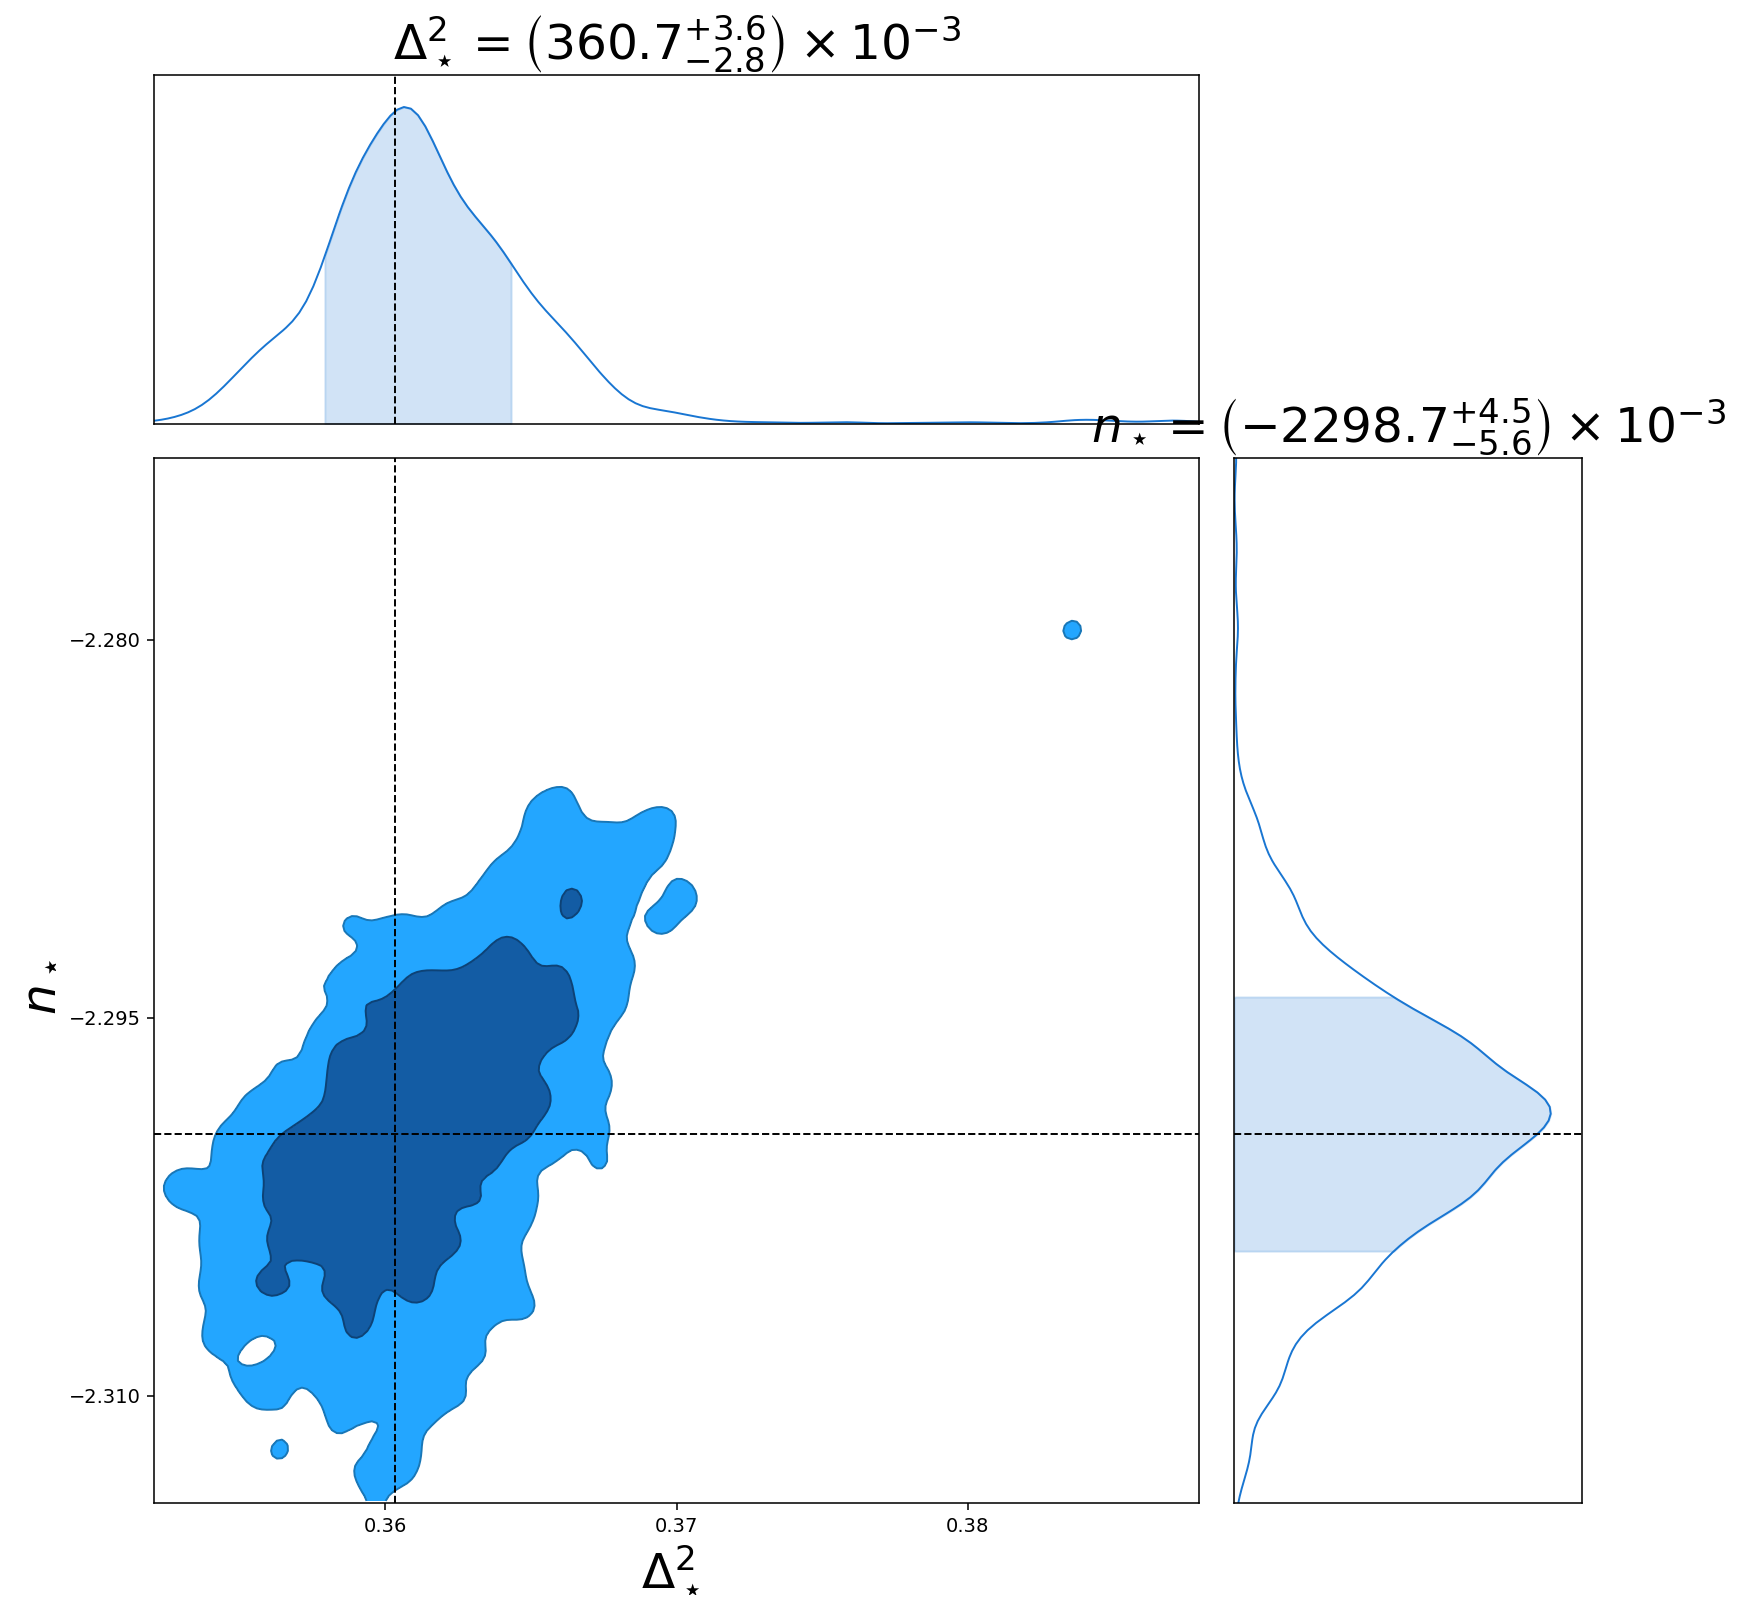

In [14]:
sampler.plot_corner(plot_params=['$\\Delta^2_\\star$','$n_\\star$'],
                    delta_lnprob_cut=50,usetex=False,serif=False)